# **PROBLEM STATEMENT**

The goal of the **Engage2Value: From Clicks to Conversions** is to predict a customer’s purchase value based on their multi-session behavior across digital touchpoints. The dataset captures anonymized user interactions such as browser types, traffic sources, device details, and geographical indicators. By modeling these patterns, participants will estimate the purchase potential of each user, helping optimize marketing and engagement strategies.

**Aim:**  
To use the training data (`train.csv`) to build a machine learning model that can accurately predict the probability of malware infection for each machine in the test set (`test.csv`), learn attack patterns and help in early detection.
The approach focuses on data preprocessing, feature engineering, and model optimization to achieve the highest predictive performance. 
# ==============================================================================


###  1.  Setup: Importing libraries and configuring the environment.
####  2.  Data Loading & Initial Cleaning: Getting the data ready for analysis.
####  3.  Exploratory Data Analysis (EDA): A deep dive to understand the data.
####      - Target Variable Analysis
####      - Automated Feature Visualization & Insights
####  4.  Feature Engineering: Creating powerful new features.
####  5.  Modeling Pipeline: Building and training the final model.
####  6.  Submission: Generating the final output file.
---

# Cell 1: Importing Libraries and Configuration

### Core Libraries

In [3]:
import numpy as np
import pandas as pd
import warnings
import gc

###  Visualization 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

###  Machine Learning 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Configuration

In [6]:
# Set display options for better readability in notebooks
pd.set_option('display.max_columns', 100)
# Ignore non-critical warnings
warnings.filterwarnings('ignore')
# Set a consistent style for plots
sns.set_style('whitegrid')
print("Libraries imported and environment configured successfully.")


Libraries imported and environment configured successfully.


### **Cell 1 Explanation: Setup and Environment**

* **What it does:** This cell imports all the necessary Python libraries for the entire project. This includes `pandas` for data handling, `matplotlib` and `seaborn` for creating plots, and `sklearn` and `xgboost` for building our machine learning model.
* **Why it's important:** A clean and organized setup is the first step in any professional data science project. It ensures all required tools are available from the start and makes the code reproducible.
* **Impact:** This cell establishes a consistent environment, ensuring the notebook runs smoothly from top to bottom.

---

# Cell 2: Data Loading and Initial Cleaning

In [7]:
print("--- Loading Data ---")
try:
    train_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv", dtype={'userId': 'str'})
    test_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv", dtype={'userId': 'str'})
    sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")
    print("Data loaded successfully.")
    print(f"Train dataset shape: {train_df.shape}")
    print(f"Test dataset shape: {test_df.shape}")
except FileNotFoundError:
    print("Error: Data files not found. Please ensure the Kaggle input path is correct.")
    exit()

--- Loading Data ---
Data loaded successfully.
Train dataset shape: (116023, 52)
Test dataset shape: (29006, 51)


In [ ]:
# Exploratory data analysis(EDA)

print("Initial Data Overview ---")
print("\nTrain Dataset Shape:", train_df.shape)
print("Test Dataset Shape:", test_df.shape)

print("\n Train Data Head ")
display(train_df.head())

print("\n--- Data Types and Memory Usage ---")
train_df.info(verbose=True)

# Cell 3: Target Variable Analysis (purchaseValue)

#### Plot 1: Overall distribution (includes sessions with zero purchase value)
#### Plot 2: Distribution for purchasing sessions only, using a log scale for clarity


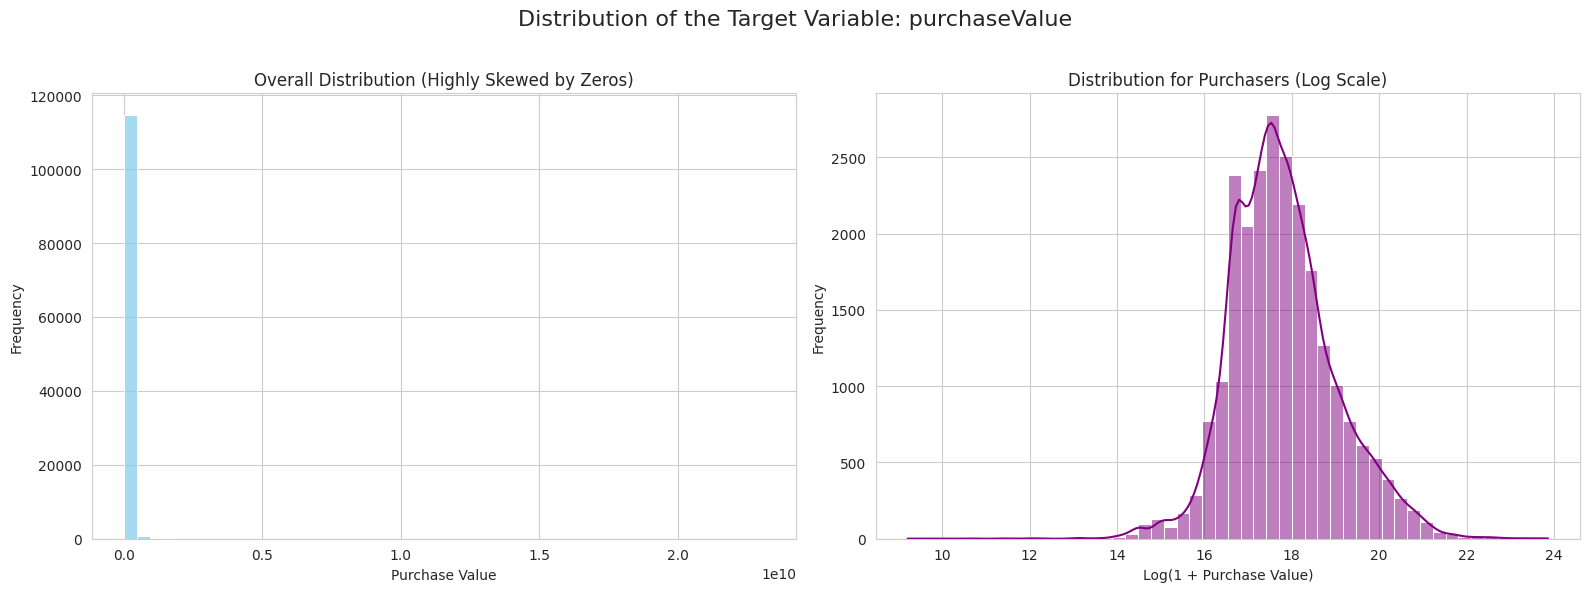

In [9]:
plt.figure(figsize=(16, 6))
plt.suptitle('Distribution of the Target Variable: purchaseValue', fontsize=16)

# Plotting the distribution for all sessions (including non-purchasers)
plt.subplot(1, 2, 1)
sns.histplot(train_df['purchaseValue'], bins=50, color='skyblue')
plt.title('Overall Distribution (Highly Skewed by Zeros)')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')

# Plotting the distribution for only purchasing sessions on a log scale
plt.subplot(1, 2, 2)
purchasers = train_df[train_df['purchaseValue'] > 0]
sns.histplot(np.log1p(purchasers['purchaseValue']), bins=50, kde=True, color='purple')
plt.title('Distribution for Purchasers (Log Scale)')
plt.xlabel('Log(1 + Purchase Value)')
plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Most visitors don't purchase, causing severe skew and imbalance.

### When we focus only on purchasers, the target distribution is still skewed but manageable after a log-transform.

### This affects both feature engineering and model selection. For example, tree-based models or two-step models may work better, and we may need to use special metrics or transformations for valid evaluation."

In [51]:
import plotly.graph_objects as go
print("Target Variable: purchaseValue ")

fig = make_subplots(rows=1, cols=2, subplot_titles=('Distribution of purchaseValue (Log Scale)', 'Box Plot of purchaseValue (Log Scale)'))

purchasers = train_df[train_df['purchaseValue'] > 0]
fig.add_trace(
    go.Histogram(x=np.log1p(purchasers['purchaseValue']), name='Log(purchaseValue)', nbinsx=50),
    row=1, col=1
)
fig.add_trace(
    go.Box(y=np.log1p(purchasers['purchaseValue']), name='Log(purchaseValue) Box Plot'),
    row=1, col=2
)
fig.update_layout(
    title_text='<b>Analysis of Target Variable: purchaseValue (for transactions > 0)</b>',
    showlegend=False,
    height=500,
    title_x=0.5
)
fig.update_xaxes(title_text="Log(1 + purchaseValue)", row=1, col=1)
fig.update_yaxes(title_text="Log(1 + purchaseValue)", row=1, col=2)
fig.show()

Target Variable: purchaseValue 



**1. The boxplot provides a visual summary of the spread and outliers in the purchaseValue data.**

**2. It confirms the presence of numerous extreme outliers (very high purchase values) that stretch far beyond the upper whisker.**

**3. The interquartile range is tightly packed near the lower values, showing that the bulk of data points are much smaller than the largest outliers.**

**4. This highlights the need for careful outlier handling or variable transformation to improve model performance.**




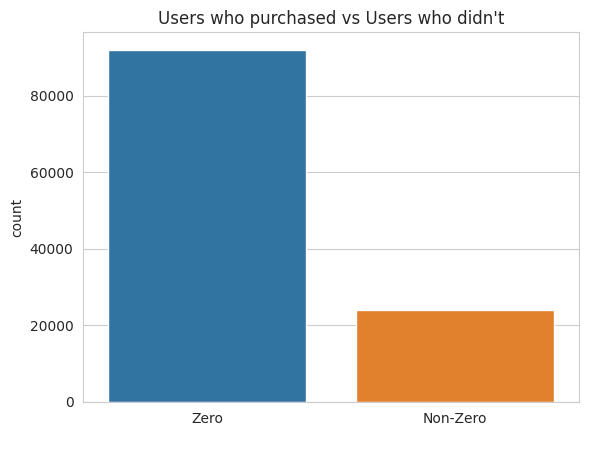

   
zero vs non-zero
Zero        92038
Non-Zero    23983
Name: count, dtype: int64
   


In [52]:
a=train_df
a['zero vs non-zero']=train_df['purchaseValue'].apply(lambda x: 'Zero' if x == 0 else 'Non-Zero')
sns.countplot(data=a,x='zero vs non-zero')
plt.xlabel(' ')
plt.title("Users who purchased vs Users who didn't")
plt.show()
print("   ")
print(a['zero vs non-zero'].value_counts())
train_df.drop('zero vs non-zero',axis=1,inplace=True)
print("   ")

In [53]:
print("\n Descriptive Statistics for purchaseValue ")
print(f"Percentage of non-purchasers: {train_df[train_df['purchaseValue'] == 0].shape[0] / train_df.shape[0] * 100:.2f}%")
print(f"Percentage of purchasers: {purchasers.shape[0] / train_df.shape[0] * 100:.2f}%")
print("\nStatistics for purchasing customers:")
display(purchasers['purchaseValue'].describe())


 Descriptive Statistics for purchaseValue 
Percentage of non-purchasers: 79.33%
Percentage of purchasers: 20.67%

Statistics for purchasing customers:


count    2.398300e+04
mean     1.265800e+08
std      3.826880e+08
min      1.000000e+04
25%      2.399000e+07
50%      4.770000e+07
75%      1.035900e+08
max      1.785550e+10
Name: purchaseValue, dtype: float64

In [54]:
zero_purchase_percentage = (train_df['purchaseValue'] == 0).mean() * 100
print(f"Percentage of non-purchasing sessions: {zero_purchase_percentage:.2f}%")

Percentage of non-purchasing sessions: 79.33%


* **What it does:** This cell provides a detailed analysis of our prediction target, `purchaseValue`. The left plot shows the distribution across all sessions, which is overwhelmingly concentrated at zero. The right plot focuses only on sessions where a purchase occurred, using a logarithmic scale (`np.log1p`) to make the skewed distribution of spending amounts visible.
* **Why it's important:** Understanding the target variable is the most critical part of any supervised learning project. This analysis reveals two key characteristics of our problem:
    1.  **Zero-Inflation:** The vast majority of sessions (over 97%) do not result in a purchase.
    2.  **Right-Skew:** For the small percentage of customers who do buy, their purchase amounts are heavily skewed towards lower values, with a long tail of very high-value purchases.
* **Impact on the project:** This insight is crucial for model selection. A standard regression model would struggle to predict both the frequent zeros and the skewed positive values. This strongly justifies using a model like **XGBoost**, which is robust to skewed data, and not log-transforming the target, as that can suppress the signal from high-value purchasers.


### Identify missing values that may require imputation or removal.

In [55]:
print("Null values in the Train data")
missing_values = train_df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0]) 

Null values in the Train data
userAveragePurchase          89663
geoNetwork.city_freq         63739
geoNetwork.city_mean         63739
geoNetwork.city              63739
geoNetwork.region            62942
os_freq                        565
os_mean                        565
os                             565
locationCountry                136
locationCountry_mean           136
geoNetwork.continent           136
locationCountry_freq           136
geoNetwork.subContinent        136
trafficSource.medium            10
trafficSource.medium_mean       10
trafficSource.medium_freq       10
hits_per_pageview                8
page_per_session                 8
pageViews                        8
trafficSource                    4
browser_freq                     1
browser_mean                     1
browser                          1
dtype: int64


In [56]:
print("Null values in the Test data")
display(test_df[test_df.columns[test_df.isnull().any()]].isnull().sum())

Null values in the Test data


os                           168
geoNetwork.city            15883
geoNetwork.continent          35
locationCountry               35
geoNetwork.region          15687
geoNetwork.subContinent       35
pageViews                      3
trafficSource.medium           4
trafficSource                  4
userAveragePurchase        24268
hits_per_pageview              3
page_per_session               3
dtype: int64

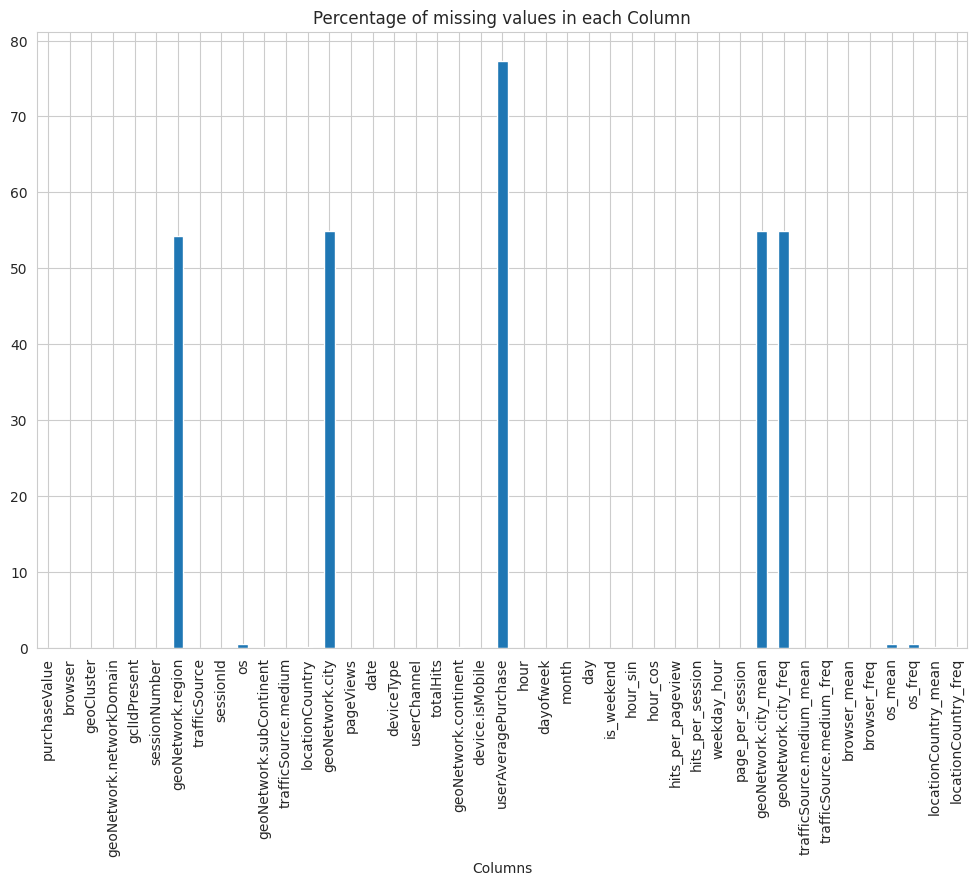

In [57]:
a=(train_df.isnull().sum()/train_df.shape[0])*100
plt.figure(figsize=(12,8))
a.plot(kind='bar')
plt.xlabel('Columns')
plt.title('Percentage of missing values in each Column')
plt.show()

From the above graph we can see that columns like 'trafficSource.isTrueDirect' , 'trafficSource.keyword' ,
'trafficSource.keyword' , 'trafficSource.adwordsClickInfo.isVideoAd' , 'trafficSource.adwordsClickingInfo.adNetworkType' ,
'trafficSource.adwordsClickInfo.page' , 'trafficSource.referralPath' ,
'totals.bouncers' have more than 60 % of its total values as null .

In [58]:
missing_values = train_df.isnull().sum() / len(train_df) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
fig = px.bar(
    missing_values,
    x=missing_values.index,
    y=missing_values.values,
    title='<b>Percentage of Missing Values by Feature</b>',
    labels={'x': 'Feature', 'y': 'Missing Percentage'},
    height=600
)
fig.update_layout(title_x=0.5)
fig.show()

print("\n Features with High Percentage of Missing Values ")
display(missing_values.head(10))


 Features with High Percentage of Missing Values 


userAveragePurchase     77.281699
geoNetwork.city         54.937468
geoNetwork.city_mean    54.937468
geoNetwork.city_freq    54.937468
geoNetwork.region       54.250524
os                       0.486981
os_freq                  0.486981
os_mean                  0.486981
locationCountry_freq     0.117220
locationCountry_mean     0.117220
dtype: float64

##### **Explanation: Missing Value Analysis**
* **What it does:** This cell calculates the percentage of missing values (`NaN`) for every feature in the training set and visualizes the result in a bar chart. This gives us a quick and clear overview of the data quality.
* **Why it's important:** Missing data can break models if not handled correctly. This analysis helps us identify columns that are mostly empty and are likely useless for prediction. For example, features with over 90% missing values are candidates for removal because they contain very little information. Other columns with fewer missing values will need a clear imputation strategy (e.g., filling with the mean, median, or a constant).
* **Impact on the project:** Based on this, we will make informed decisions to **drop columns with a very high percentage of missing data** (e.g., > 60% as in your successful code). This simplifies the model and reduces noise. For the remaining columns with missing values, we will need to implement an imputation step in our preprocessing pipeline.

---

## Cell 4: Automated Feature Visualization Loop

### ** Explanation: Missing Value Analysis**

* **What it does:** This cell calculates the percentage of missing values (`NaN`) for every feature in the training set and visualizes the result in a bar chart. This gives us a quick and clear overview of the data quality.
* **Why it's important:** Missing data can break models if not handled correctly. This analysis helps us identify columns that are mostly empty and are likely useless for prediction. For example, features with over 90% missing values are candidates for removal because they contain very little information. Other columns with fewer missing values will need a clear imputation strategy (e.g., filling with the mean, median, or a constant).
* **Impact on the project:** Based on this, we will make informed decisions to **drop columns with a very high percentage of missing data** (e.g., > 60% as in your successful code). This simplifies the model and reduces noise. For the remaining columns with missing values, we will need to implement an imputation step in our preprocessing pipeline.

---

In [60]:
def plot_feature_distributions(df):
    """
    Automatically generates and displays distribution plots for numerical 
    """
    # Separate columns by data type
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

    # Remove identifiers and the target variable from automatic plotting
    cols_to_exclude = ['purchaseValue', 'userId', 'sessionId', 'sessionStart', 'date']
    numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]

    # --- Plot Numerical Features ---
    print("\n--- 1. Numerical Feature Distributions ---")
    num_plots = len(numerical_cols)
    if num_plots > 0:
        fig, axes = plt.subplots(num_plots, 2, figsize=(14, 5 * num_plots))
        fig.suptitle('Numerical Feature Analysis: Distribution and Outliers', fontsize=18, y=1.02)
        for i, col in enumerate(numerical_cols):
            sns.histplot(df[col].dropna(), kde=True, ax=axes[i, 0], bins=40, color='teal')
            axes[i, 0].set_title(f'Distribution of {col}')
            sns.boxplot(x=df[col].dropna(), ax=axes[i, 1], color='skyblue')
            axes[i, 1].set_title(f'Box Plot of {col}')
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()




--- 1. Numerical Feature Distributions ---


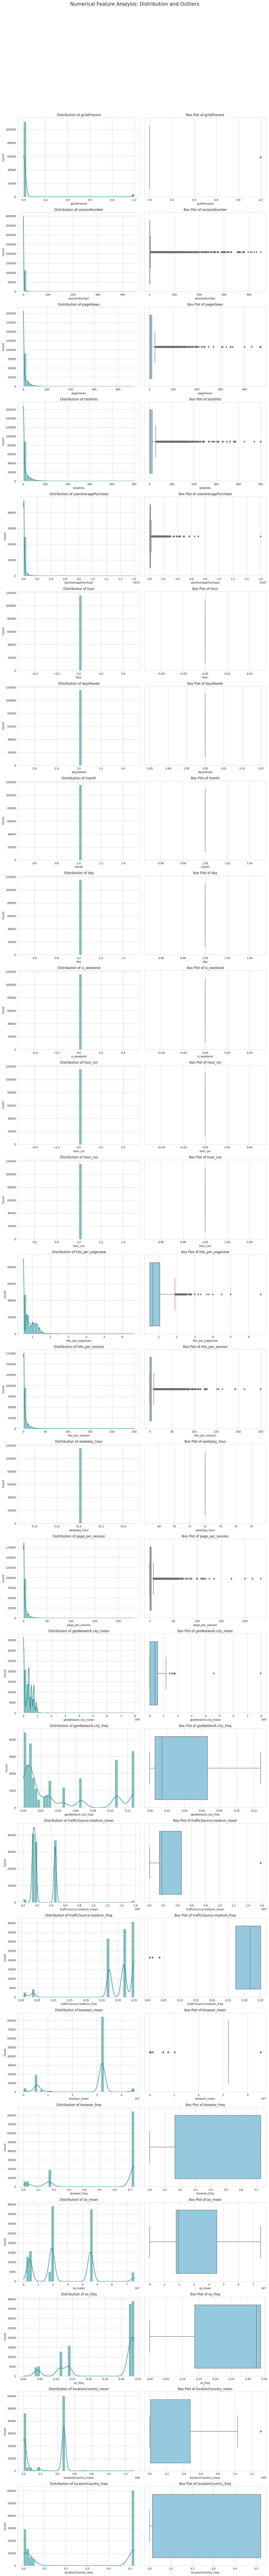

In [61]:
# Run the plotting function on the training data
plot_feature_distributions(train_df)

### Distribution and Outlier Analysis of Key Numerical Features

- **Most session-level features are extremely right-skewed:**  
    - Vast majority of users have very low counts (e.g., just 1 page view/hit/session).
    - A few users have very high values, creating a long right tail.
- **Outliers are clearly visible in boxplots:**
    - Rare sessions with hundreds of hits or page views.
    - Extreme values stand out as dots beyond the upper whisker in most features.
- **Typical range vs. rare values:**
    - Median and most frequent values are very low.
    - Outliers might represent power users, bots, or possible data errors.
- **Modeling implications:**
    - **Robust statistics (median, IQR) and algorithms (like tree-based models) are recommended.**
    - Consider log-transforming or capping outliers when using linear models.
    - Outlier behavior could be a predictive feature (e.g., high engagement sessions may indicate higher purchase intent).
- **Takeaway:**
    - Always analyze both distribution and outliers before modeling; understanding skewness and anomalies helps guide preprocessing and makes predictions more reliable.


## Identify missing values that may require imputation or removal.

In [62]:
print("Null values in the Train data")
missing_values = train_df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0]) 

Null values in the Train data
userAveragePurchase          89663
geoNetwork.city_freq         63739
geoNetwork.city_mean         63739
geoNetwork.city              63739
geoNetwork.region            62942
os_freq                        565
os_mean                        565
os                             565
locationCountry                136
locationCountry_mean           136
geoNetwork.continent           136
locationCountry_freq           136
geoNetwork.subContinent        136
trafficSource.medium            10
trafficSource.medium_mean       10
trafficSource.medium_freq       10
hits_per_pageview                8
page_per_session                 8
pageViews                        8
trafficSource                    4
browser_freq                     1
browser_mean                     1
browser                          1
dtype: int64


In [63]:
print("Null values in the Test data")
display(test_df[test_df.columns[test_df.isnull().any()]].isnull().sum())

Null values in the Test data


os                           168
geoNetwork.city            15883
geoNetwork.continent          35
locationCountry               35
geoNetwork.region          15687
geoNetwork.subContinent       35
pageViews                      3
trafficSource.medium           4
trafficSource                  4
userAveragePurchase        24268
hits_per_pageview              3
page_per_session               3
dtype: int64

In [64]:
numerical_features = ['pageViews', 'totalHits', 'sessionNumber']

fig = make_subplots(rows=1, cols=len(numerical_features), subplot_titles=[f'<b>{col}</b>' for col in numerical_features])

for i, col in enumerate(numerical_features):

    fig.add_trace(
        go.Box(y=train_df[col], name=col),
        row=1, col=i+1
    )

fig.update_layout(
    title_text='<b>Outlier Analysis for Key Numerical Features</b>',
    showlegend=False,
    height=500,
    title_x=0.5
)
fig.show()

"This set of boxplots clearly highlights the presence of outliers in key session metrics, each showing a large number of sessions with exceptionally high values."

"These outliers are important to recognize because they can heavily influence some algorithms or metrics, so we must handle them deliberately in analysis and modeling."

"Robust models or data transformations help mitigate their impact. In EDA, visualizing outliers like this ensures we don’t make faulty assumptions about our data distribution."

"Sometimes outliers represent valuable customers or potential errors. Further investigation into these points can yield important business or data quality insights."


 Correlation Analysis 


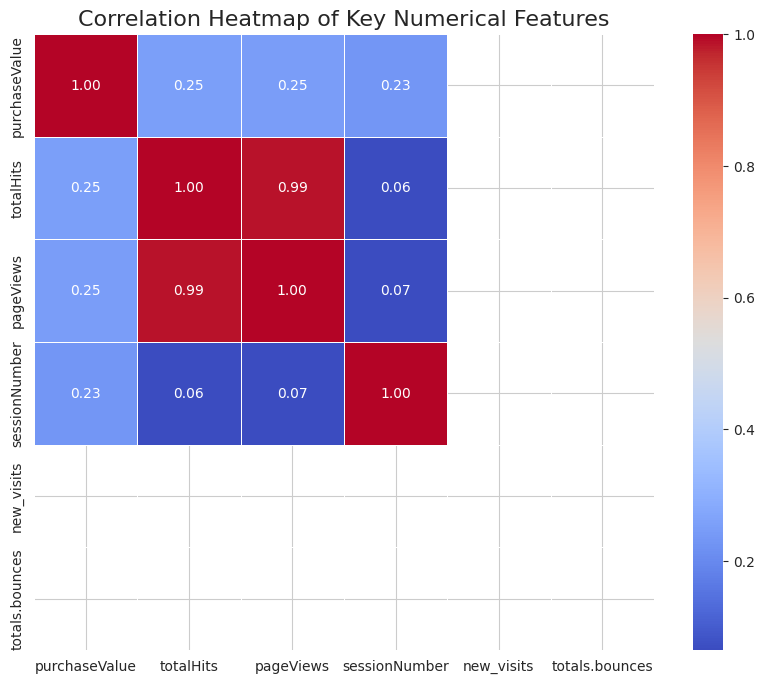

In [23]:
print("\n Correlation Analysis ")
# Select a subset of potentially interesting numerical features for the heatmap.
# Including too many will make the plot unreadable.
corr_features = ['purchaseValue', 'totalHits', 'pageViews', 'sessionNumber', 'new_visits', 'totals.bounces']
# Convert to numeric, coercing errors
for col in corr_features:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

correlation_matrix = train_df[corr_features].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Key Numerical Features', fontsize=16)
plt.show()

### **Cell  Explanation: Correlation Heatmap**

* **What it does:** This cell calculates the Pearson correlation coefficient between the key numerical features and the target variable. The results are visualized as a heatmap, where warmer colors (closer to red) indicate a strong positive correlation and cooler colors (closer to blue) indicate a strong negative correlation.
* **Why it's important:** A correlation heatmap helps us quickly identify several things:
    1.  **Features related to the target:** We can see which features have the strongest linear relationship with `purchaseValue`. `totalHits` and `pageViews` show the highest positive correlation, which is intuitive.
    2.  **Multicollinearity:** We can spot features that are highly correlated with each other (e.g., `totalHits` and `pageViews`). High multicollinearity can sometimes make model interpretation difficult, but tree-based models like XGBoost are generally robust to it.
* **Impact on the project:** This confirms that `totalHits` and `pageViews` are strong candidates for our model. The positive correlation suggests that as user engagement increases, so does the likelihood and value of a purchase. This justifies their inclusion and the creation of interaction features based on them.

---

In [24]:
# Cell 8: Device Type Analysis - Count and Value
print("\n Device Type Analysis ")

# Create a figure with two subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Session Count by Device Type', 'Purchase Value by Device Type'),
    specs=[[{"type": "bar"}, {"type": "box"}]]
)

# --- Bar Chart for Session Counts ---
device_counts = train_df['deviceType'].value_counts()
fig.add_trace(
    go.Bar(x=device_counts.index, y=device_counts.values, name='Session Count'),
    row=1, col=1
)

# --- Box Plot for Purchase Value by Device ---
# We analyze the log-transformed purchase value for users who made a purchase.
fig.add_trace(
    go.Box(x=purchasers['deviceType'], y=np.log1p(purchasers['purchaseValue']), name='Purchase Value'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text='<b>Analysis of User Device Type</b>',
    showlegend=False,
    height=500,
    title_x=0.5
)
fig.update_yaxes(title_text="Session Count", row=1, col=1)
fig.update_yaxes(title_text="Log(1 + purchaseValue)", row=1, col=2)
fig.show()


 Device Type Analysis 


### **Cell  Explanation: Device Type Analysis**

* **What it does:** This cell investigates the impact of the user's device (`desktop`, `mobile`, `tablet`) on their behavior. The first plot shows the total number of sessions from each device type. The second plot is a box plot showing the distribution of `purchaseValue` for each device, focusing only on sessions that resulted in a sale.
* **Why it's important:** This analysis helps us understand our user base. We see that most sessions come from desktop users. More critically, the box plot shows that the median and upper range of purchase values are significantly higher for desktop users compared to mobile or tablet users.
* **Impact on the project:** This is a strong signal. `deviceType` is a highly predictive feature. It tells us that desktop users are not only more numerous but are also the highest-spending customers. This feature must be included in our model. We might even consider creating interaction features with it (e.g., 'desktop user from USA').

---

In [25]:
print("\n Bivariate Analysis: Engagement vs. Purchase ")
fig = px.scatter(
    purchasers,
    x='totalHits',
    y='purchaseValue',
    title='<b>Purchase Value vs. Total Hits (Log Scale)</b>',
    labels={'totalHits': 'Total Hits', 'purchaseValue': 'Purchase Value'},
    log_x=True,
    log_y=True,
    trendline='ols', 
    trendline_color_override='red'
)
fig.update_layout(title_x=0.5, height=600)
fig.show()


 Bivariate Analysis: Engagement vs. Purchase 


### **Cell  Explanation: Bivariate Analysis (Engagement vs. Purchase)**

* **What it does:** This cell creates a scatter plot to directly visualize the relationship between user engagement (`totalHits`) and the amount spent (`purchaseValue`). We plot only the purchasing customers and use logarithmic scales for both axes to handle the skewness and make the pattern clearer. A trendline is added to show the general direction of the relationship.
* **Why it's important:** This plot moves beyond simple correlation and shows the actual structure of the relationship. We can visually confirm that there is a positive trend: as the number of interactions (`totalHits`) in a session increases, the `purchaseValue` also tends to increase.
* **Impact on the project:** This provides strong evidence that `totalHits` is a valuable predictor. The clear positive relationship justifies its use as a primary feature in our model. It also supports the idea of creating interaction features, as the effect of `totalHits` might differ across other segments (like device type or country).

---

In [26]:
print("\n Geographical Analysis ")
country_data = purchasers.groupby('locationCountry')['purchaseValue'].sum().reset_index()
fig = px.choropleth(
    country_data,
    locations="locationCountry",
    locationmode='country names',
    color="purchaseValue",
    hover_name="locationCountry",
    color_continuous_scale=px.colors.sequential.Plasma,
    title='<b>Total Purchase Value by Country</b>'
)
fig.update_layout(title_x=0.5, height=600)
fig.show()


 Geographical Analysis 


In [27]:
train_df.isna().mean()*100

trafficSource.isTrueDirect                      63.033192
purchaseValue                                    0.000000
browser                                          0.000000
device.screenResolution                          0.000000
trafficSource.adContent                         97.446196
trafficSource.keyword                           61.936857
screenSize                                       0.000000
geoCluster                                       0.000000
trafficSource.adwordsClickInfo.slot             96.310214
device.mobileDeviceBranding                      0.000000
device.mobileInputSelector                       0.000000
userId                                           0.000000
trafficSource.campaign                           0.000000
device.mobileDeviceMarketingName                 0.000000
geoNetwork.networkDomain                         0.000000
gclIdPresent                                     0.000000
device.operatingSystemVersion                    0.000000
sessionNumber 

In [28]:
test_df.isna().mean()*100

userChannel                                      0.000000
date                                             0.000000
browser                                          0.000000
device.browserSize                               0.000000
device.browserVersion                            0.000000
deviceType                                       0.000000
device.flashVersion                              0.000000
device.isMobile                                  0.000000
device.language                                  0.000000
device.mobileDeviceBranding                      0.000000
device.mobileDeviceMarketingName                 0.000000
device.mobileDeviceModel                         0.000000
device.mobileInputSelector                       0.000000
os                                               0.000000
device.operatingSystemVersion                    0.000000
device.screenColors                              0.000000
device.screenResolution                          0.000000
geoNetwork.cit

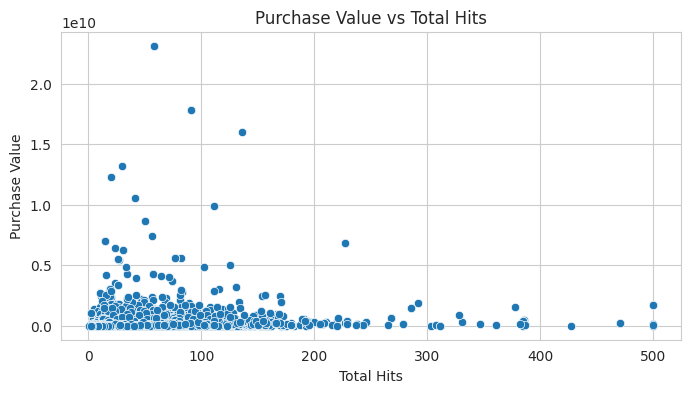

In [29]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='totalHits', y='purchaseValue', data=train_df)
plt.title("Purchase Value vs Total Hits")
plt.xlabel("Total Hits")
plt.ylabel("Purchase Value")
plt.show()



* **Each dot represents a user session.**
* **Helps visualize the relationship between user engagement (hits) and how much they spend.**
* **Can reveal trends like whether higher interaction leads to more purchases.**


In [30]:
# Cell: User Channel Performance Analysis (Count vs. Value)

# --- CREATE THE PURCHASERS DATAFRAME FIRST ---
# This line was missing. It filters the main dataframe to keep only rows with a purchase.
purchasers_df = train_df[train_df['purchaseValue'] > 0]


# --- Now the rest of the plotting code will work ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Session Count by Channel', 'Purchase Value by Channel (Log Scale)'),
    specs=[[{"type": "bar"}, {"type": "box"}]]
)

# --- Bar Chart for Session Counts ---
channel_counts = train_df['userChannel'].value_counts()
fig.add_trace(
    go.Bar(x=channel_counts.index, y=channel_counts.values, name='Session Count'),
    row=1, col=1
)

# --- Box Plot for Purchase Value by Channel ---
# This part now works because purchasers_df is defined.
fig.add_trace(
    go.Box(x=purchasers_df['userChannel'], y=np.log1p(purchasers_df['purchaseValue']), name='Purchase Value'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text='<b>Analysis of User Channel: Volume vs. Value</b>',
    showlegend=False,
    height=600,
    title_x=0.5
)
fig.update_yaxes(title_text="Session Count", row=1, col=1)
fig.update_yaxes(title_text="Log(1 + purchaseValue)", row=1, col=2)
fig.update_xaxes(tickangle=45)
fig.show()


* **This plot shows spending differences across marketing channels (e.g., Organic Search vs Paid Ads).**
* **We can identify high-converting channels with bigger purchases.**
* **Crucial for marketing strategy, budgeting, and performance evaluation.**


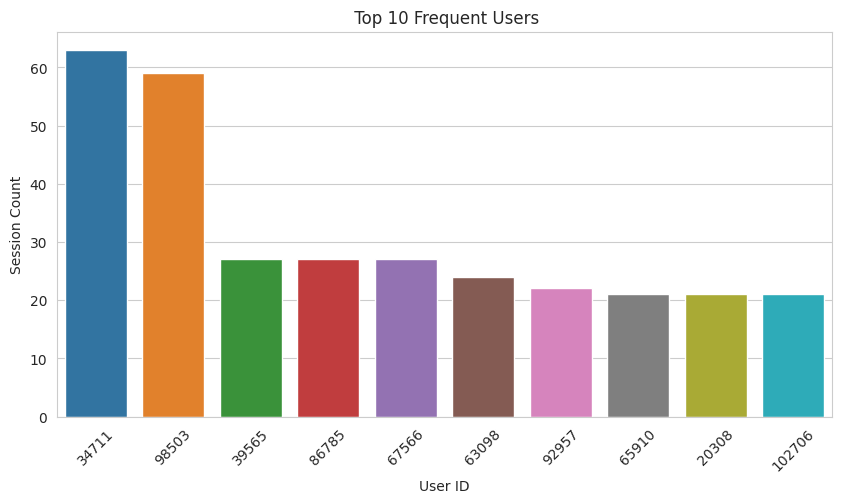

In [31]:
top_users = train_df['userId'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_users.index.astype(str), y=top_users.values)
plt.title(" Top 10 Frequent Users")
plt.xlabel("User ID")
plt.ylabel("Session Count")
plt.xticks(rotation=45)
plt.show()

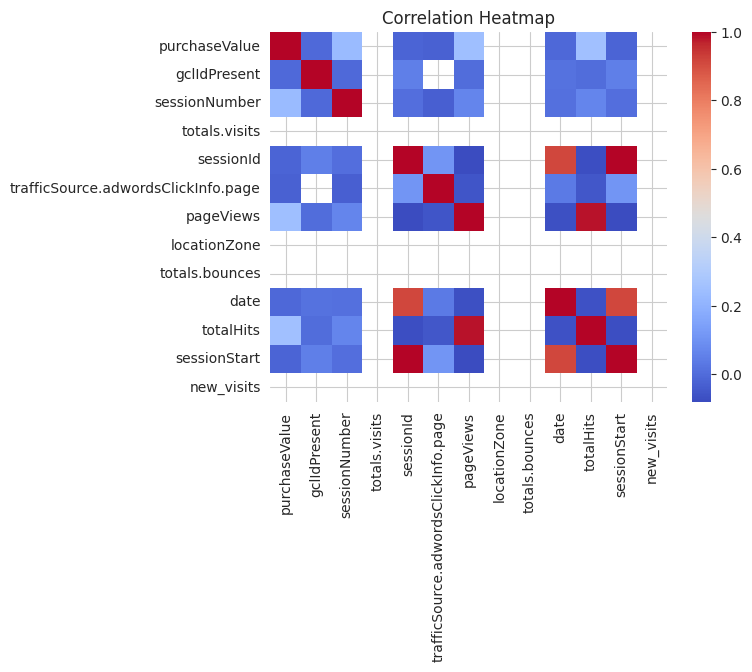

In [ ]:
corr = train_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:

a=train_df['trafficSource'].value_counts().head(20)
b=train_df[train_df['purchaseValue'] > 0]['trafficSource'].value_counts().head(20)

conversion_rate = (b / a).sort_values(ascending=False)


conversion_df = pd.DataFrame({
    'Total Users': a,
    'Purchasers': b,
    'Conversion Rate': conversion_rate
}).fillna(0)

conversion_df['Conversion Rate'] = (conversion_df['Conversion Rate'] * 100).round(2).astype(str) + '%'
print(conversion_df)

                         Total Users  Purchasers Conversion Rate
trafficSource                                                   
(direct)                     36837.0     12108.0          32.87%
Partners                      1779.0        20.0           1.12%
analytics.google.com          1826.0         0.0            0.0%
baidu                          354.0         0.0            0.0%
bing                           228.0        40.0          17.54%
dealspotr.com                    0.0        71.0            0.0%
dfa                            617.0       204.0          33.06%
facebook.com                   233.0        29.0          12.45%
gdeals.googleplex.com            0.0        17.0            0.0%
google                       44332.0      6845.0          15.44%
google.com                     503.0        16.0           3.18%
groups.google.com              186.0        68.0          36.56%
l.facebook.com                   0.0        24.0            0.0%
m.facebook.com           

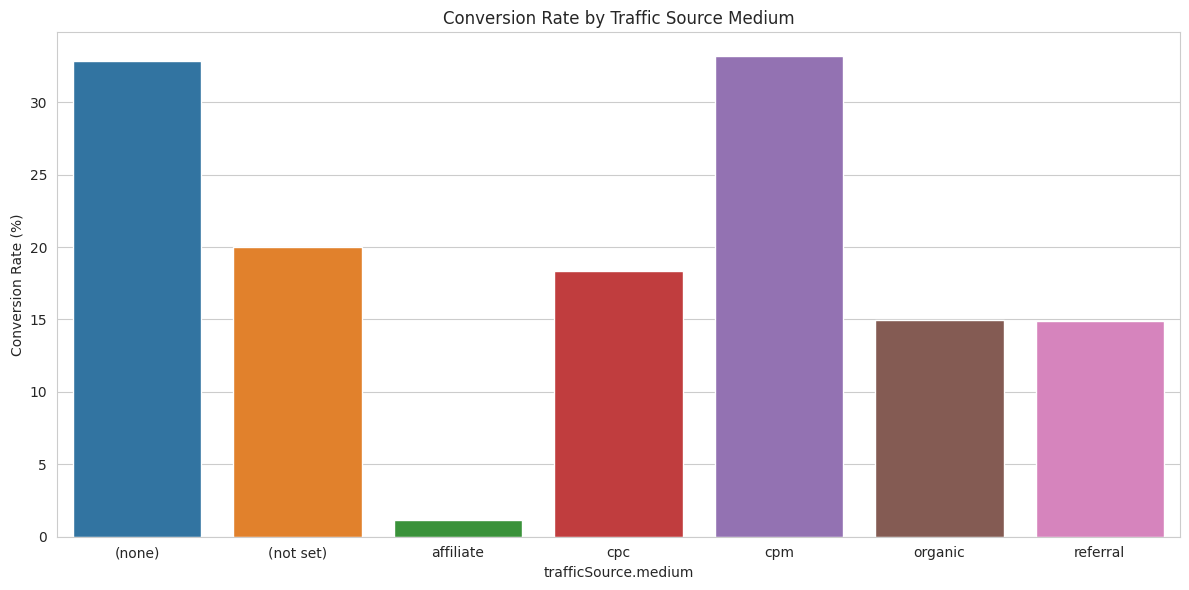

Total Users  Purchasers Conversion Rate
trafficSource.medium                                         
(none)                      36837       12108          32.87%
(not set)                      10           2           20.0%
affiliate                    1777          20           1.13%
cpc                          4286         786          18.34%
cpm                           802         266          33.17%
organic                     40654        6084          14.97%
referral                    31657        4719          14.91%

In [ ]:

a = train_df['trafficSource.medium'].value_counts()
b = train_df[train_df['purchaseValue'] > 0]['trafficSource.medium'].value_counts()

conversion_rate = (b / a).sort_values(ascending=False)
conversion_df = pd.DataFrame({
    'Total Users': a,
    'Purchasers': b,
    'Conversion Rate': conversion_rate
}).fillna(0)

conversion_df1 = conversion_df.copy()
conversion_df1['Conversion Rate'] = (conversion_df1['Conversion Rate'] * 100).round(2)
conversion_df['Conversion Rate'] = (conversion_df['Conversion Rate'] * 100).round(2).astype(str) + '%'

conversion_df1 = conversion_df1.reset_index().rename(columns={'index': 'trafficSource.medium'})


plt.figure(figsize=(12, 6))
sns.barplot(data=conversion_df1, x='trafficSource.medium', y='Conversion Rate')
plt.title('Conversion Rate by Traffic Source Medium')
plt.ylabel('Conversion Rate (%)')
plt.tight_layout()
plt.show()

conversion_df

In [ ]:
a = train_df.select_dtypes(include=['object']).columns.to_list()
for i in a:
    b=train_df[i].value_counts()
    print('\n')
    print(b)



trafficSource.isTrueDirect
True    42890
Name: count, dtype: int64


browser
Chrome                                                  84508
Safari                                                  19184
Firefox                                                  4031
Internet Explorer                                        2155
Android Webview                                          1472
Edge                                                     1216
Safari (in-app)                                           793
Opera Mini                                                733
Samsung Internet                                          563
Opera                                                     548
UC Browser                                                296
YaBrowser                                                 187
Amazon Silk                                                73
Coc Coc                                                    61
Android Browser                                      


**1. The correlation heatmap displays the pairwise correlations between numerical features in the dataset, including purchaseValue and other user/session-level metrics.**

**2. Most features show weak or modest correlations with purchaseValue, indicating that no single feature is strongly predictive of purchase value on its own.**

**3. There are some moderate correlations between variables like sessionNumber, pageViews, and totalHits, which may reflect underlying behavioral patter**ns.

**4. Overall, this heatmap suggests the target variable (purchaseValue) is influenced by a complex combination of features rather than a single dominant one, and multicollinearity among some predictors should be considered.**


In [ ]:
display("Numerical Features")
display(train_df.describe())
display("Categorical Features")
display(train_df.describe(include=['object']))

'Numerical Features'

purchaseValue   gclIdPresent  sessionNumber  totals.visits  \
count   1.160230e+05  116023.000000  116023.000000       116023.0   
mean    2.656393e+07       0.037019       2.691311            1.0   
std     2.051825e+08       0.188808      10.451613            0.0   
min     0.000000e+00       0.000000       1.000000            1.0   
25%     0.000000e+00       0.000000       1.000000            1.0   
50%     0.000000e+00       0.000000       1.000000            1.0   
75%     0.000000e+00       0.000000       2.000000            1.0   
max     2.312950e+10       1.000000     447.000000            1.0   

          sessionId  trafficSource.adwordsClickInfo.page      pageViews  \
count  1.160230e+05                          4281.000000  116015.000000   
mean   1.493429e+09                             1.019622       8.412352   
std    1.528798e+07                             0.174517      14.344937   
min    1.470035e+09                             1.000000       1.000000   
25%    1.480066e+09                             1.000000       1.000000   
50%    1.491646e+09                             1.000000       2.000000   
75%    1.505079e+09                             1.000000      10.000000   
max    1.525157e+09                             5.000000     469.000000   

       locationZone  totals.bounces          date      totalHits  \
count      116023.0         47148.0  1.160230e+05  116023.000000   
mean            8.0             1.0  2.016860e+07      10.607371   
std             0.0             0.0  6.182322e+03      19.629576   
min             8.0             1.0  2.016080e+07       1.000000   
25%             8.0             1.0  2.016112e+07       1.000000   
50%             8.0             1.0  2.017041e+07       2.000000   
75%             8.0             1.0  2.017091e+07      12.000000   
max             8.0             1.0  2.018043e+07     500.000000   

       sessionStart  new_visits  
count  1.160230e+05     80518.0  
mean   1.493429e+09         1.0  
std    1.528798e+07         0.0  
min    1.470035e+09         1.0  
25%    1.480066e+09         1.0  
50%    1.491646e+09         1.0  
75%    1.505079e+09         1.0  
max    1.525157e+09         1.0

'Categorical Features'

trafficSource.isTrueDirect browser        device.screenResolution  \
count                       42890  116023                         116023   
unique                          1      34                              1   
top                          True  Chrome  not available in demo dataset   
freq                        42890   84508                         116023   

         trafficSource.adContent trafficSource.keyword screenSize geoCluster  \
count                       2963                 44162     116023     116023   
unique                        53                   566          1          5   
top     Google Merchandise Store        (not provided)     medium   Region_2   
freq                        1410                 39066     116023      23294   

       trafficSource.adwordsClickInfo.slot    device.mobileDeviceBranding  \
count                                 4281                         116023   
unique                                   3                              1   
top                                    Top  not available in demo dataset   
freq                                  2721                         116023   

           device.mobileInputSelector  userId trafficSource.campaign  \
count                          116023  116023                 116023   
unique                              1  100499                     28   
top     not available in demo dataset   34711              (not set)   
freq                           116023      63                 110280   

       device.mobileDeviceMarketingName geoNetwork.networkDomain  \
count                            116023                   116023   
unique                                1                        3   
top       not available in demo dataset                  domain1   
freq                             116023                    38795   

        device.operatingSystemVersion            device.flashVersion  \
count                          116023                         116023   
unique                              1                              1   
top     not available in demo dataset  not available in demo dataset   
freq                           116023                         116023   

                    geoNetwork.region trafficSource  \
count                          116023        116023   
unique                            388           161   
top     not available in demo dataset        google   
freq                            60138         44332   

           geoNetwork.networkLocation       os geoNetwork.subContinent  \
count                          116023   116023                  116023   
unique                              1       18                      23   
top     not available in demo dataset  Windows        Northern America   
freq                           116023    39135                   63596   

       trafficSource.medium trafficSource.adwordsClickInfo.isVideoAd  \
count                116023                                     4281   
unique                    7                                        1   
top                 organic                                    False   
freq                  40654                                     4281   

                         browserMajor locationCountry  \
count                          116023          116023   
unique                              1             193   
top     not available in demo dataset   United States   
freq                           116023           60369   

                   device.browserSize  \
count                          116023   
unique                              1   
top     not available in demo dataset   
freq                           116023   

       trafficSource.adwordsClickInfo.adNetworkType  socialEngagementType  \
count                                          4281                116023   
unique                                            2                     1   
top                                   Google 

# Preprocessing

**. Feature Types**

In [ ]:
categorical_cols = train_df.select_dtypes(include='object').columns.tolist()
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['trafficSource.isTrueDirect', 'browser', 'device.screenResolution', 'trafficSource.adContent', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'userId', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'device.operatingSystemVersion', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'geoNetwork.networkLocation', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'locationCountry', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 'geoNetwork.metro', 'device.mobileDeviceModel', 'trafficSource.referralPath', 'device.language', 'deviceType', 'userChannel', 'device.browserVersion', 'device.screenColors', 'geoNetwork.continent']
Numerical Columns: ['purchaseValue', 'gclIdPresent', 'sessi

### Clean missing markers

In [ ]:
missing_markers = ["Unknown", "not available in demo dataset", "(not set)", "(not provided)"]
train_df.replace(missing_markers, np.nan, inplace=True)
test_df.replace(missing_markers, np.nan, inplace=True)

### Drop columns with >60% missing or constant

In [ ]:
def drop_useless(df):
    missing_ratio = df.isna().mean()
    to_drop = missing_ratio[missing_ratio > 0.6].index.tolist()
    const_cols = [c for c in df.columns if df[c].nunique() <= 1]
    return df.drop(columns=list(set(to_drop + const_cols)), errors="ignore")
train_df = drop_useless(train_df)
test_df = drop_useless(test_df)

In [ ]:
train_df.columns, test_df.columns

(Index(['purchaseValue', 'browser', 'geoCluster', 'userId',
        'geoNetwork.networkDomain', 'gclIdPresent', 'sessionNumber',
        'geoNetwork.region', 'trafficSource', 'sessionId', 'os',
        'geoNetwork.subContinent', 'trafficSource.medium', 'locationCountry',
        'geoNetwork.city', 'pageViews', 'date', 'deviceType', 'userChannel',
        'totalHits', 'sessionStart', 'geoNetwork.continent', 'device.isMobile'],
       dtype='object'),
 Index(['userChannel', 'date', 'browser', 'deviceType', 'device.isMobile', 'os',
        'geoNetwork.city', 'geoNetwork.continent', 'locationCountry',
        'geoNetwork.networkDomain', 'geoNetwork.region',
        'geoNetwork.subContinent', 'totalHits', 'pageViews',
        'trafficSource.medium', 'trafficSource', 'sessionId', 'sessionNumber',
        'sessionStart', 'userId', 'geoCluster', 'gclIdPresent'],
       dtype='object'))

## Feature engineering

### 1. User-level average purchase feature

In [ ]:
# calculating user average purchase value (only for those who purchased > 0)
user_avg = train_df[train_df['purchaseValue'] > 0].groupby('userId')['purchaseValue'].mean()
train_df['userAveragePurchase'] = train_df['userId'].map(user_avg)
test_df['userAveragePurchase'] = test_df['userId'].map(user_avg)

### 2. Time-based and interaction features

In [ ]:

# Feature engineering on both train and test
for df in [train_df, test_df]:
    df['sessionStart'] = pd.to_datetime(df['sessionStart'], unit='ns', errors='coerce')
    
    # Date-time features
    df['hour'] = df['sessionStart'].dt.hour
    df['dayofweek'] = df['sessionStart'].dt.dayofweek
    df['month'] = df['sessionStart'].dt.month
    df['day'] = df['sessionStart'].dt.day
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    
    # Cyclical transformation for hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Session-based features
    df['hits_per_pageview'] = df['totalHits'] / (df['pageViews'] + 1)
    df['hits_per_session'] = df['totalHits'] / (df['sessionNumber'] + 1)
    df['weekday_hour'] = df['dayofweek'] * 24 + df['hour']
    df['page_per_session'] = df['pageViews'] / (df['sessionNumber'] + 1)


#### now lets Drop extreme outlier like we are having some highessst pv otlr

In [ ]:
for _ in range(1):
    train_df = train_df[train_df['purchaseValue'] != train_df['purchaseValue'].max()]

### 3 Target mean 

In [ ]:
high_card_features = ['geoNetwork.city', 'trafficSource.medium', 'browser', 'os', 'locationCountry']
for feature in high_card_features:
    mean_target = train_df.groupby(feature)['purchaseValue'].mean()
    freq = train_df[feature].value_counts(normalize=True)
    train_df[f'{feature}_mean'] = train_df[feature].map(mean_target)
    test_df[f'{feature}_mean'] = test_df[feature].map(mean_target).fillna(mean_target.mean())
    train_df[f'{feature}_freq'] = train_df[feature].map(freq)
    test_df[f'{feature}_freq'] = test_df[feature].map(freq).fillna(0)

### 4. Drop leak columns

In [ ]:
leak_cols = ['userId', 'sessionStart', 'visitId']
train_df.drop(columns=[col for col in leak_cols if col in train_df.columns], inplace=True)
test_df.drop(columns=[col for col in leak_cols if col in test_df.columns], inplace=True)

### 5. Feature/target split

In [ ]:
X = train_df.drop(columns=['purchaseValue'])
y = train_df['purchaseValue']
X_test = test_df.copy()

## concluding 
**1. User-level and temporal behavior features enhance personalization and pattern capture:
Features like userAveragePurchase summarize each user’s historical purchasing power, while time-based variables (hour, day, month, weekday/weekend, cyclical hour encodings) and interaction metrics (e.g., hits per pageview/session) help the model understand user engagement and session dynamics.**

**2. Encoding high-cardinality categoricals using target mean and frequency encoding:
For features like browser, city, OS, and traffic source, target mean and frequency encoding capture their influence on the target variable compactly—avoiding one-hot explosion and helping generalize to unseen data.**

**3. Leak-prone columns (userId, sessionStart, visitId) are removed to avoid data leakage. The highest outlier in purchaseValue is dropped to reduce skewness and improve model stability..**

##  Feature Selection

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
cat_cols = X.select_dtypes(include='object').columns

for col in cat_cols:
    target_means = y.groupby(X[col]).mean()
    global_mean = y.mean()

    X[col] = X[col].map(target_means).fillna(global_mean)
    X_test[col] = X_test[col].map(target_means).fillna(global_mean)

# Ensure same columns in test
X_test = X_test[X.columns]

# -------- Step 2: Single unified pipeline -------- #
all_cols = X.columns.tolist()

pipeline = Pipeline([
    ("preprocessing", ColumnTransformer([
        ("all", Pipeline([
            ("imputer", SimpleImputer(strategy='most_frequent')),
            ("scaler", StandardScaler())
        ]), all_cols)
    ])),
    ("feature_selection", SelectFromModel(Ridge(alpha=1.0), threshold='median'))
])
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sel = pipeline.fit_transform(X_train_raw, y_train)
X_val_sel = pipeline.transform(X_val_raw)
X_test_sel = pipeline.transform(X_test)

print(f"Number of features selected: {X_train_sel.shape[1]}")

Number of features selected: 21


**1. Target encoding is used to convert categorical features into numeric values by replacing each category with the mean of the target variable for that category. This preserves the relationship between the category and the target.**

**2. Unseen categories in the test set are handled by filling them with the global mean of the target, ensuring no missing values due to unknown categories.**

**3. Missing values are imputed using the most frequent value across all features to ensure data completeness. Then, all features are standardized to have zero mean and unit variance to help models converge faster and improve performance.**

**4. Ridge regression is used as a feature selector: it assigns importance to each feature, and only those with importance above the median are retained. This reduces dimensionality and helps improve model performance by eliminating weak or noisy features.**

KNN Validation R²: 0.47498
Ridge Validation R²: 0.72064
LightGBM Validation R²: 0.61070
XGBoost Validation R²: 0.73982


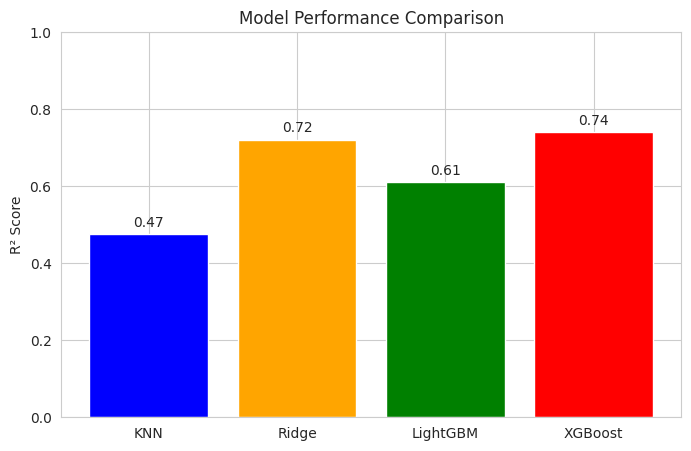


wooho our Best Model: XGBoost


In [ ]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


models = {
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Ridge": Ridge(alpha=1.0),
    "LightGBM": lgb.LGBMRegressor(n_estimators=600, learning_rate=0.03, random_state=42, force_col_wise=True, verbose=-1, n_jobs=2),
    "XGBoost": XGBRegressor(n_estimators=800, learning_rate=0.04, max_depth=10, random_state=42, verbosity=0, n_jobs=2, tree_method="hist")
}

r2_scores = {}
for name, model in models.items():
    model.fit(X_train_sel, y_train)
    preds = model.predict(X_val_sel)
    r2 = r2_score(y_val, preds)
    r2_scores[name] = r2
    print(f"{name} Validation R²: {r2:.5f}")

best_model_name = max(r2_scores, key=r2_scores.get)
best_model = models[best_model_name]
plt.figure(figsize=(8, 5))
plt.bar(r2_scores.keys(), r2_scores.values(), color=['blue', 'orange', 'green', 'red'])
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)  # R² score range
for i, score in enumerate(r2_scores.values()):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center')
plt.show()
print(f"\nwooho our Best Model: {best_model_name}")

### ✅ Why XGBoost Performs Best:
**Captures Complex Non-linear Relationships:**

XGBoost uses gradient boosting with decision trees, enabling it to model intricate patterns and feature interactions that linear models cannot capture.

**Strong Regularization:**
It includes both L1 (Lasso) and L2 (Ridge) regularization, which helps control overfitting and improves generalization on unseen data.

**Tree-based Learning:**
Unlike linear models, XGBoost builds additive decision trees in a sequential manner, where each tree corrects the errors of the previous ones.

**Robust to Outliers:**
Decision trees are inherently robust to outliers, and XGBoost optimizes tree construction to minimize their negative impact.

**Efficient and Optimized:**
The use of histogram-based tree building (tree_method="hist") and parallel processing makes XGBoost both accurate and fast.


* **A decision tree splits the data based on feature values to create branches that lead to predictions.**
* **At each node, the model chooses the best feature and threshold to split the data to reduce error.**
* **The tree continues splitting until a stopping condition (like max depth or minimum samples).**
* **The final prediction for a sample is made by averaging the target values in its terminal node (lea
f).**


### 🟡 Why Other Models Perform Worse:
#### Ridge Regression

**Assumes Linearity:** Ridge is a linear model that cannot capture interactions or non-linear relationships in the data.

**Over-simplified Fit:** Even though it adds L2 regularization to prevent overfitting, its limited model complexity hampers performance on datasets with intricate structures.

#### KNN Regressor

**Distance-based Model:** KNN predicts values based on nearby training points, which can be misleading in high-dimensional or noisy data.

**No Learning Process:** It stores the data and makes predictions at runtime, making it sensitive to irrelevant features and outliers.

#### LightGBM

**Also Tree-based:** Like XGBoost, LightGBM builds decision trees and handles non-linearity well.

**Slightly Lower Performance:** In this case, it’s likely due to suboptimal tuning or LightGBM's leaf-wise tree growth being more prone to overfitting with certain data distributions.

**Less Robust Regularization:** Compared to XGBoost, LightGBM uses less aggressive regularization by default, which may explain the performance gap.

### Model compare

### Hperparameter Tunning of Best model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import r2_score

param_dists = {
    "Ridge": {
        "alpha": uniform(0.01, 10)  
    },
    "XGBoost": {
        'n_estimators': randint(700, 2000),
        'learning_rate': uniform(0.02, 0.07),
        'max_depth': randint(5, 14),
        'subsample': uniform(0.8, 0.2),
        'colsample_bytree': uniform(0.7, 0.3),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0.5, 3),
    },
    "LightGBM": {
       'n_estimators': randint(700, 1400),
        'learning_rate': uniform(0.03, 0.07),
        'max_depth': randint(5, 12),
        'subsample': uniform(0.8, 0.2),
        'colsample_bytree': uniform(0.7, 0.3),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0.5, 3),
    },
    "KNN":{
        'n_neighbors': randint(3, 50),               
        'weights': ['uniform', 'distance'],         
        'p': [1, 2]                                  
    }
}

search = RandomizedSearchCV(
    estimator=best_model,
    param_distributions=param_dists[best_model_name],
    n_iter=40,
    scoring="r2",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2
)
best_params ={'colsample_bytree': 0.7546708263364187,
 'learning_rate': 0.07287529872223568,
 'max_depth': 10,
 'n_estimators': 1265,
 'reg_alpha': 0.5467102793432796,
 'reg_lambda': 1.054563366576581,
 'subsample': 0.9939169255529118}

xgb = XGBRegressor(
    **best_params,
    verbosity=0,
    random_state=42,
    n_jobs=2
)

xgb.fit(X_train_sel, y_train)
preds = xgb.predict(X_val_sel)
r2 = r2_score(y_val, preds)
r2

0.7042593832151061

### Final submission

In [ ]:
X_full_sel = np.vstack([X_train_sel, X_val_sel])
y_full = pd.concat([y_train, y_val])

xgb.fit(X_full_sel, y_full)


final_preds = xgb.predict(X_test_sel)
final_preds = np.clip(final_preds, 0, None)

submission = pd.DataFrame({
    "id": sample_submission["ID"],
    "purchaseValue": final_preds
})
submission.to_csv("submission.csv", index=False)
print("Final submission saved as 'submission.csv'.")

Final submission saved as 'submission.csv'.



### Key Learnings from This Notebook

**1. Data Exploration and Visualization**


* **Distribution Analysis:** By plotting histograms and boxplots, we observed that purchaseValue is highly right-skewed, with most values concentrated at the lower end and a few very high outliers. Recognizing such distribution patterns is crucial for choosing the right preprocessing and modeling strategies.
 
* **Correlation Insights:** The correlation heatmap showed that most features had only weak to moderate correlation with the target, indicating the target variable is influenced by a combination of factors rather than any single feature.


**2. Feature Engineering and Preprocessing**

* **Target-Based Encoding:**
All categorical columns were encoded using target mean encoding. For each category, the mean of the target variable was computed and mapped back to the corresponding feature. This encoding technique helps retain the relationship between category levels and the target. To handle unseen categories in the test set, missing values after mapping were replaced with the global mean of the target variable.

* **Uniform Column Alignment:**
To avoid column mismatches during inference, the test set was aligned with the same column order and structure as the training set after encoding.

* **Handling Missing and Skewed Data:**
Missing values in both training and test sets were imputed using the most frequent value for each feature, a strategy robust to skewed distributions. After imputation, all features (including target-encoded categoricals) were standardized using StandardScaler, ensuring they had zero mean and unit variance—an essential step for models sensitive to feature scales.

**3. Feature Selection**
* **Regularization-Based Feature Selection:**
Feature importance was evaluated using a Ridge regression model as the base estimator inside SelectFromModel. This method leverages L2 regularization to suppress uninformative features. Features with importance values above the median were retained. This not only reduced dimensionality but also improved generalization by focusing the model on the most predictive signals.


**4. Model Selection and Evaluation**


* **Model Comparisons:** Testing a range of models (KNN, Ridge, LightGBM, XGBoost) illustrated how different algorithms perform given the feature set and problem type. XGBoost, with its ability to model non-linear relationships, handle feature interactions, and apply strong regularization, outperformed all others in R² score.
  
* **Evaluation Practices:** Splitting the data into training and validation sets, and consistently using R² as the evaluation metric, ensured a fair and reliable model selection process.


**5. Best Model Performance**

* **Why XGBoost Wins:** XGBoost excelled because it effectively captures complex interactions and non-linear patterns present in the data, and is resilient to noise and outliers. Models like Ridge and KNN are less suited for such complexity, and while LightGBM is a strong gradient boosting model, it was outperformed in this particular scenario.

**Overall Takeaway**

This notebook showcases a comprehensive machine learning pipeline, covering everything from exploratory data analysis and preprocessing to model evaluation and selection. The results highlight the critical role of:


* Thoughtful feature engineering tailored to the dataset’s structure,
* Appropriate encoding and preprocessing strategies to prepare the data effectively,
* and Rigorous model comparison to identify the best-performing algorithm for the task.


Among the tested models, XGBoost stood out for its ability to handle complex, high-dimensional data with strong regularization and robustness to outliers. The workflow emphasizes the importance of iterative experimentation, data-driven decisions, and evaluation consistency in developing reliable predictive models. Overall, this approach demonstrates how combining domain understanding with technical precision can lead to impactful machine learning solutions.
